Задача состоит в том, чтобы оценить, сколько в пиковые моменты потребления у нас в
эти дни происходило одновременных соединений с документами (ситуация в которой несколько пользователей одновременно находятся внутри документа) и визуализировать на
подходящей для этого диаграмме.

Сейчас на всех серверах
одновременно, исходя из нашего тарифа, мы можем предоставить пользователям не
более 3000 одновременных подключений.

В результате анализа нужно увидеть, насколько далеко мы от  лимитов в 3000 одновремнных подключений к документу. Также
найти в данных, что сильнее всего влияет на величину одновременных подключений.
Т.е. если бы мы захотели их уменьшить, с какого типа пользователей или порталов нам
стоило бы начать.

Предполагаемый алоритм выполнения:
1. Просмотр информации о данных: пропуски, уникальные значения, формат даннных и т.п.
2. Создание нового столбца, который будет содержать значение 1 для каждой строки (с целью дальнейшего подсчета количества подлючений).
3. Создание нового столбца с длительностью подключения -  разница между `start_edit_time` и `conn_end_time`.
4. Группировка данных по времени и подсчет общего количества подключений для каждого временного интервала.
5. Создание линейной диаграммы для визуализироования количества одновременных подключений во времени.
6. Определить максимальное количество одновременных подключений и сравнить его с лимитом в 3000.
7. Используя группировку и агрегацию, определить, какие типы пользователей или порталов имеют наибольшее влияние на количество одновременных подключений.
8. Выводы и рекомендации для уменьшения количества одновременных подключений, если это необходимо.

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
data = pd.read_csv(r'task_data.csv')
data.info()
# общая информация о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103486 entries, 0 to 103485
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   server           103485 non-null  object 
 1   portal_type      103484 non-null  object 
 2   db_name          103484 non-null  object 
 3   tariff_id        103484 non-null  object 
 4   user             103484 non-null  object 
 5   doc_id           103484 non-null  float64
 6   start_edit_time  103484 non-null  object 
 7   conn_end_time    103484 non-null  object 
dtypes: float64(1), object(7)
memory usage: 6.3+ MB


In [43]:
data_counts = data.nunique()
data_counts

server                 5
portal_type            2
db_name             9297
tariff_id            141
user               34653
doc_id             96304
start_edit_time    66728
conn_end_time      64301
dtype: int64

In [44]:
data.head()

,server,portal_type,db_name,tariff_id,user,doc_id,start_edit_time,conn_end_time
0,de,box,augcrm.com,box,137augcrm.com,2.152628e+09,12/4/2022 8:07:25 AM,12/5/2022 9:39:44 AM
1,de,box,portal.dalidovitch.com,box,5193portal.dalidovitch.com,3.846962e+09,12/4/2022 3:14:08 PM,12/5/2022 9:11:30 AM
2,ms,cloud,b22452522,ru_pro100,148b22452522,2.382197e+09,12/4/2022 8:14:43 PM,12/5/2022 12:00:26 AM
3,us,cloud,b14804373,la_std,1b14804373,2.372717e+09,12/4/2022 9:08:03 PM,12/5/2022 3:57:19 AM
4,ru,cloud,b12009830,ru_company,250603b12009830,3.757262e+09,12/4/2022 9:42:07 PM,12/5/2022 1:19:32 AM


In [45]:
data.tail()

,server,portal_type,db_name,tariff_id,user,doc_id,start_edit_time,conn_end_time
103481,ms,cloud,b3162457,ru_pro,134078b3162457,4.444441e+06,12/6/2022 11:57:07 PM,12/6/2022 11:59:55 PM
103482,de,box,asesores-e.net,box,20089asesores-e.net,2.740667e+09,12/6/2022 11:57:18 PM,12/7/2022 1:01:16 AM
103483,us,cloud,b22043033,br_std,17b22043033,1.361046e+09,12/6/2022 11:58:00 PM,12/6/2022 11:58:25 PM
103484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103485,Applied filters:\nIncluded (3) 2022 (Year) + Q...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видим незначимые строки в конце датасета. Проверим количество пропусков по всей таблице

In [46]:
data.isnull().sum(axis=0)
data.isna().sum(axis=0)

server             1
portal_type        2
db_name            2
tariff_id          2
user               2
doc_id             2
start_edit_time    2
conn_end_time      2
dtype: int64

Обнаруживаем, что причина пропусков в последних двух строках - удалим их:

In [47]:
data = data.drop(labels=[103484,103485], axis=0)

Создаем новый столбец, содержащий int значение 1, для дальнейшего подсчета подключений:

In [48]:
data['connections'] = 1

Приведем столбцы с датами/временем к нужному формату:

In [49]:
data['start_edit_time'] = pd.to_datetime(data['start_edit_time'], format='%m/%d/%Y %I:%M:%S %p')
data['conn_end_time'] = pd.to_datetime(data['conn_end_time'], format='%m/%d/%Y %I:%M:%S %p')

Отдельно рассмотрим оба столбца, чтоб не упустить возможные ошибки при сохранении/передачи данных:

In [50]:
data['start_edit_time'].describe()

C:\Users\orlov\AppData\Local\Temp\ipykernel_9820\137691672.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['start_edit_time'].describe()


count                  103484
unique                  66728
top       2022-12-06 13:31:30
freq                       10
first     2022-12-04 08:07:25
last      2022-12-06 23:58:00
Name: start_edit_time, dtype: object

In [51]:
data['start_edit_time'].isnull().value_counts()

False    103484
Name: start_edit_time, dtype: int64

In [52]:
data['conn_end_time'].describe()

C:\Users\orlov\AppData\Local\Temp\ipykernel_9820\3228499562.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['conn_end_time'].describe()


count                  103484
unique                  64301
top       2022-12-06 13:31:30
freq                       46
first     2022-12-05 00:00:01
last      2022-12-07 01:30:50
Name: conn_end_time, dtype: object

In [53]:
data['conn_end_time'].isnull().value_counts()

False    103484
Name: conn_end_time, dtype: int64

Пропущенных значений нет, аномалий не обнаружено. 
Можно приступить к созданию нового столбца, содержащего количество времени, проведенному внутри документа для каждой строки

In [54]:
data['time_diff_minutes'] = round((data['conn_end_time'] - data["start_edit_time"]).dt.total_seconds() / 60 , 2)
data['time_diff_minutes']

0         1532.32
1         1077.37
2          225.72
3          409.27
4          217.42
           ...   
103479       2.98
103480      33.95
103481       2.80
103482      63.97
103483       0.42
Name: time_diff_minutes, Length: 103484, dtype: float64

Посмотрим на статитистику полученного столбца:

In [55]:
data['time_diff_minutes'].describe(include = 'all')

count    103484.000000
mean         21.169020
std          36.171972
min           0.000000
25%           2.380000
50%           7.750000
75%          31.020000
max        1693.700000
Name: time_diff_minutes, dtype: float64

Видим максимальное значение (1693), соответсвующее примерно 28 часам работы внутри документа. Т.к. провести столько времени за непрерывным редактированием не представляется высоковероятным, рассмотрим ближе этот случай, а также этого пользователя:

In [56]:
data.loc[data['time_diff_minutes'] == max(data['time_diff_minutes'])]

,server,portal_type,db_name,tariff_id,user,doc_id,start_edit_time,conn_end_time,connections,time_diff_minutes
6077,ms,box,bitrix24.academcity.online,box,2640bitrix24.academcity.online,213865233.0,2022-12-05 08:38:57,2022-12-06 12:52:39,1,1693.7


In [57]:
max_index = data['time_diff_minutes'].idxmax()
anomalous_user = data.loc[max_index, 'user']

user_rows = data[data['user'] == anomalous_user]
user_rows

,server,portal_type,db_name,tariff_id,user,doc_id,start_edit_time,conn_end_time,connections,time_diff_minutes
2760,ms,box,bitrix24.academcity.online,box,2640bitrix24.academcity.online,8.508831e+08,2022-12-05 07:02:56,2022-12-05 11:45:14,1,282.30
6077,ms,box,bitrix24.academcity.online,box,2640bitrix24.academcity.online,2.138652e+08,2022-12-05 08:38:57,2022-12-06 12:52:39,1,1693.70
20983,ms,box,bitrix24.academcity.online,box,2640bitrix24.academcity.online,1.840935e+09,2022-12-05 11:55:12,2022-12-05 11:56:25,1,1.22
28800,ms,box,bitrix24.academcity.online,box,2640bitrix24.academcity.online,6.375231e+08,2022-12-05 13:40:25,2022-12-05 13:55:05,1,14.67
40850,ms,box,bitrix24.academcity.online,box,2640bitrix24.academcity.online,1.607628e+09,2022-12-05 16:21:10,2022-12-05 16:22:27,1,1.28
61280,ms,box,bitrix24.academcity.online,box,2640bitrix24.academcity.online,1.960408e+09,2022-12-06 09:11:33,2022-12-06 09:15:41,1,4.13
77473,ms,box,bitrix24.academcity.online,box,2640bitrix24.academcity.online,1.425896e+09,2022-12-06 13:00:12,2022-12-06 13:02:10,1,1.97
86492,ms,box,bitrix24.academcity.online,box,2640bitrix24.academcity.online,3.975508e+09,2022-12-06 15:10:19,2022-12-06 15:12:35,1,2.27


Один из возможных вариантов такого высокого времени - входы и выходы в тот же документ в промежуток времени между стартом и концом редактирования в аномальной строчке. Но такой вариант не подтвердился, значит дело либо в качестве сбора данных, либо в тонкостях, которые нужно уточнять для конкретного источника. Попробуем отыскать список подобных в дальнейших шагах.

Посмотрим на данные, превышающие 3 квантиль (75%) по количеству уделенного документам времени:

In [58]:
filtered_data = data.loc[data['time_diff_minutes'] > data['time_diff_minutes'].describe(include = 'all')['75%']]
sorted_data = filtered_data.sort_values(by='time_diff_minutes')
sorted_data

,server,portal_type,db_name,tariff_id,user,doc_id,start_edit_time,conn_end_time,connections,time_diff_minutes
67027,ru,cloud,b19999406,ru_std,1473b19999406,1.754036e+09,2022-12-06 10:32:22,2022-12-06 11:03:24,1,31.03
43420,ru,cloud,b21037576,ru_std,25b21037576,1.885075e+09,2022-12-05 17:00:56,2022-12-05 17:31:58,1,31.03
27855,ms,cloud,b5685667,ru_pro,274406b5685667,2.234684e+09,2022-12-05 13:27:35,2022-12-05 13:58:37,1,31.03
97649,us,cloud,b18231481,br_pro,6779b18231481,2.062911e+09,2022-12-06 18:18:28,2022-12-06 18:49:30,1,31.03
46423,ru,cloud,b8280485,ru_team_2019,155b8280485,2.446210e+09,2022-12-05 17:54:06,2022-12-05 18:25:08,1,31.03
...,...,...,...,...,...,...,...,...,...,...
24091,ms,cloud,b13663838,ru_ent250,1276b13663838,2.876977e+09,2022-12-05 12:36:18,2022-12-06 11:51:35,1,1395.28
13047,ms,cloud,b23029484,ru_pro100,14b23029484,2.979688e+09,2022-12-05 10:17:36,2022-12-06 11:34:07,1,1516.52
0,de,box,augcrm.com,box,137augcrm.com,2.152628e+09,2022-12-04 08:07:25,2022-12-05 09:39:44,1,1532.32
12162,ru,cloud,b10260161,ru_company,18801b10260161,1.299575e+09,2022-12-05 10:05:56,2022-12-06 12:16:00,1,1570.07


Видим аналогичные высокие значения, встречающиеся неоднократно. Построим ящик с усами:

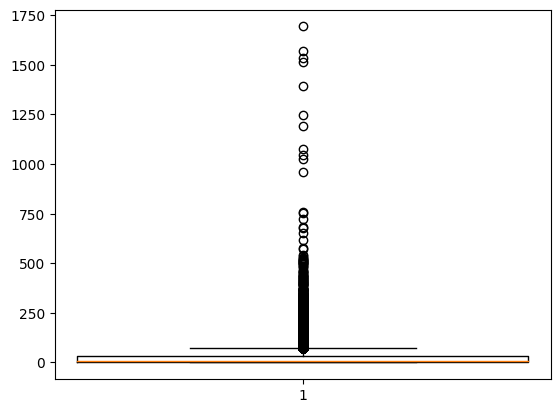

In [59]:
import matplotlib.pyplot as plt

plt.boxplot(data['time_diff_minutes'], widths = 3)
plt.show()

Видим частые выбросы, посмотрим на плотность распределения:

<AxesSubplot: xlabel='time_diff_minutes', ylabel='Density'>

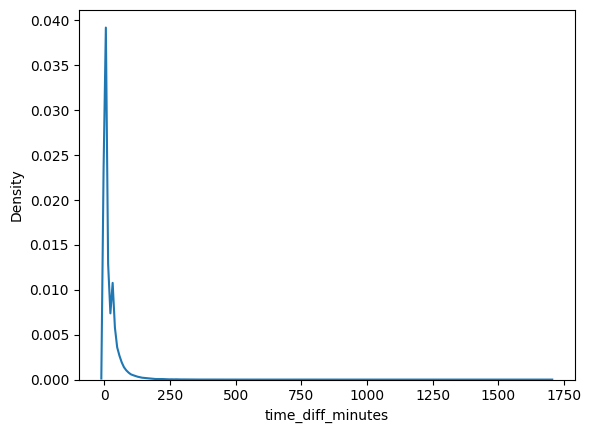

In [60]:

sns.kdeplot(data['time_diff_minutes'])


Здесь мы чуть лучше видим в какой момент начинают выбросы, найдем их програмно:

Определим, как много даннных с аномально большим временем мы имеем: напишем функцию, помогающую найти выбросы (точка данных является выбросом, если она находится на расстоянии более 1.5xIQR выше третьего квартиля или ниже первого квартиля. Иначе говоря, низкие выбросы находятся ниже Q1 - 1.5xIQR, а высокие выбросы - выше Q3 + 1.5xIQR2)

In [61]:
def find_outliers_IQR(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

In [62]:

sorted_data_time = find_outliers_IQR(data['time_diff_minutes']).sort_values()
sorted_data_time

28580      74.00
45714      74.00
20193      74.00
30402      74.00
21540      74.02
          ...   
24091    1395.28
13047    1516.52
0        1532.32
12162    1570.07
6077     1693.70
Name: time_diff_minutes, Length: 5604, dtype: float64

Определили, что выбросом начинается считаться время пребывания в документе, соотвествующее 74 минутам. Посмотрим какой процент данных лежит выше этой точки: 

In [63]:
strange_time = float((data['time_diff_minutes'] > 74).sum())
all_time = float(data.shape[0])
print(round(100*strange_time/all_time , 2), f'% аномально большого времени за документом, общее число составило {int(strange_time)} ')

5.41 % аномально большого времени за документом, общее число составило 5600 


5,41% довольно маленький процент, тут стоило бы уточнить у разработчиков/инженеров по поставке данных о возможных причинах и тогда делать выводы о том, следует ли учитывать полученные числа. Предположим, вариант развития событий, при котором такие данные необходимо оставить и принимать в учет. 
Тогда нужно найти источники длительного подключения, потому как именно такие увеличивают общее кол-во подключения перманентно: их сложно рассматривать в разрезе времени.

In [64]:
higt_time_data = data[data['time_diff_minutes'] > 74]
high_time_users = higt_time_data['user'].unique()
count_high_time_users = len(high_time_users)
count_all_users = len(data['user'].unique())
print(f'Пользователи с необычно длителными сессиями внутри документа составляют {round(100*count_high_time_users/count_all_users, 3)} % от общего числа уникальных пользователей, их общее количество составило {count_high_time_users}')

Пользователи с необычно длителными сессиями внутри документа составляют 10.617 % от общего числа уникальных пользователей, их общее количество составило 3679


Десятая часть пользователей это довольно весомая категория, которую нужно детально рассматривать отдельно. Посмотрим на их tariff_id, т.к. обработать 3,5 тысячи уникальных юзеров довольно проблематично.

In [65]:
higt_time_tariff = higt_time_data['tariff_id'].unique()
count_higt_time_tariff = len(higt_time_tariff)
count_all_tariff = len(data['tariff_id'].unique())
print(f'Источники захода на документ с анмально большим временем редактирования составляют {round(100*count_higt_time_tariff/count_all_tariff, 3)} % от общего числа пользователей, их общее количество {count_higt_time_tariff}')
higt_time_tariff

Источники захода на документ с анмально большим временем редактирования составляют 62.411 % от общего числа пользователей, их общее количество 88


array(['box', 'ru_pro100', 'la_std', 'ru_company', 'la_pro', 'ru_pro',
       'en_company', 'ru_nfr', 'ru_team_2019', 'ru_std', 'ua_pro',
       'br_company', 'ua_team_2019', 'ua_std', 'ru_ent250', 'en_pro',
       'la_company', 'br_pro', 'en_pro100', 'vn_pro100', 'br_std',
       'kz_pro', 'kz_company', 'en_ent250', 'en_team_2019', 'vn_pro',
       'by_company', 'kz_ent250', 'ru_ent500', 'in_company', 'in_pro',
       'kz_pro100', 'ru_team', 'pl_team_2019', 'kz_nfr', 'kz_std',
       'de_pro', 'by_std', 'pl_pro', 'en_std', 'ru_company2', 'de_ent500',
       'by_pro', 'by_team_2019', 'by_pro100', 'de_company', 'by_ent500',
       'ua_company', 'pl_company', 'eu_pro', 'eu_company', 'fr_pro',
       'by_team', 'fr_company', 'eu_ent250', 'fr_pro100', 'pl_std',
       'it_pro', 'de_team_2019', 'de_std', 'kz_team_2019', 'fr_std',
       'ru_ent1000', 'kz_team', 'ru_demo', 'it_company', 'br_pro100',
       'eu_std', 'la_team_2019', 'eu_pro100', 'br_ent1000',
       'br_team_2019', 'in_std', 

Именно на обозначенные источники необходимо сделать акцент в выявлении причин, по которым пользователи длительное время не прекращают работу с документом. 

In [66]:
higt_time_server = higt_time_data['server'].unique()
count_higt_time_server = len(higt_time_server)
count_all_server = len(data['server'].unique())
print(f'Сервера с анмально большим временем редактирования составляют {round(100*count_higt_time_server/count_all_server, 3)} % от общего числа пользователей, их общее количество {count_higt_time_server}')
higt_time_server

Сервера с анмально большим временем редактирования составляют 100.0 % от общего числа пользователей, их общее количество 4


array(['de', 'ms', 'us', 'ru'], dtype=object)

Видим, что  сервера прямо не влияют на количетсво подключений и время пребывания в документе.

Теперь можем перейти к выявлению количества одновременных подключений в документы.

Для это создадим временные интервалы в 30 минут и посмотрим на количество одновременных подключений по времени:

In [67]:
# создание нового столбца с округленным временем
data['start_edit_time'] = data['start_edit_time'].dt.round('30T')

# группировка данных по округленному времени
grouped_start_time = data.groupby('start_edit_time')

# подсчет общего количества подключений для каждого временного интервала
connections = grouped_start_time['connections'].agg('sum')

# сохранение результатов в новый DataFrame

connections_df = connections.reset_index()
connections_df.sort_values(ascending=False, by = 'connections').head() 


,start_edit_time,connections
32,2022-12-05 11:30:00,2448
31,2022-12-05 11:00:00,2420
33,2022-12-05 12:00:00,2403
30,2022-12-05 10:30:00,2372
29,2022-12-05 10:00:00,2368


In [68]:
def get_tariff(group):
    return list(group['tariff_id'].unique())

def get_open_docs(group):
    return list(group['doc_id'].unique())

def get_portal_type(group):
    return list(group['portal_type'].unique())

def get_db_name(group):
    return list(group['db_name'].unique())

def get_server(group):
    return list(group['server'].unique())

grouped_start_time = data.groupby('start_edit_time')
connections = grouped_start_time['connections'].agg('sum')
tariff_id = grouped_start_time.apply(get_tariff)
server = grouped_start_time.apply(get_server)
doc_id = grouped_start_time.apply(get_open_docs)
portal_type = grouped_start_time.apply(get_portal_type)
db_name = grouped_start_time.apply(get_db_name)
connections_df = pd.DataFrame({'start_edit_time': connections.index, 'connections': connections.values,  'tariff_id': tariff_id.values,  'doc_id': doc_id.values, 'portal_type': portal_type.values, 'db_name': db_name.values, 'server':server.values})
connections_df.sort_values(ascending=False, by = 'connections').head() 

,start_edit_time,connections,tariff_id,doc_id,portal_type,db_name,server
32,2022-12-05 11:30:00,2448,"[ru_pro, ru_team_2019, ru_pro100, box, ru_std,...","[2761575866.0, 1015119789.0, 2125628358.0, 101...","[cloud, box]","[b22098008, b18576430, b16130674, b20768210, b...","[ms, ru, de, us]"
31,2022-12-05 11:00:00,2420,"[ru_pro, ru_team_2019, box, by_pro, ru_team, r...","[2506519679.0, 3099009545.0, 3150537226.0, 207...","[cloud, box]","[b2751613, b6531417, rimgroup24.ru, b21176728,...","[ms, ru, de, us]"
33,2022-12-05 12:00:00,2403,"[ru_company, kz_pro100, ru_std, en_pro, box, r...","[2076029986.0, 286956681.0, 1143265116.0, 1735...","[cloud, box]","[b1621421, b20617868, b21915266, b20830995, bi...","[ru, de, ms, us]"
30,2022-12-05 10:30:00,2372,"[ru_nfr, ru_pro100, ru_team_2019, ru_company, ...","[1583791929.0, 1857497282.0, 230433439.0, 2252...","[cloud, box]","[b3808793, b21629026, b9199145, b1335383, b190...","[ru, ms, de, us]"
29,2022-12-05 10:00:00,2368,"[ru_company, in_pro, box, ru_pro, ru_team_2019...","[1447678939.0, 3093109634.0, 3675466533.0, 132...","[cloud, box]","[b11780146, b18297514, b20199223, bitrix.tdgt....","[ms, ru, us, de]"


Такую таблицу удобно использовать для ручного анализа, однако для построения визуализации нужно будет вновь вернуть исходных формат, не содержащий списков внутри колонок.

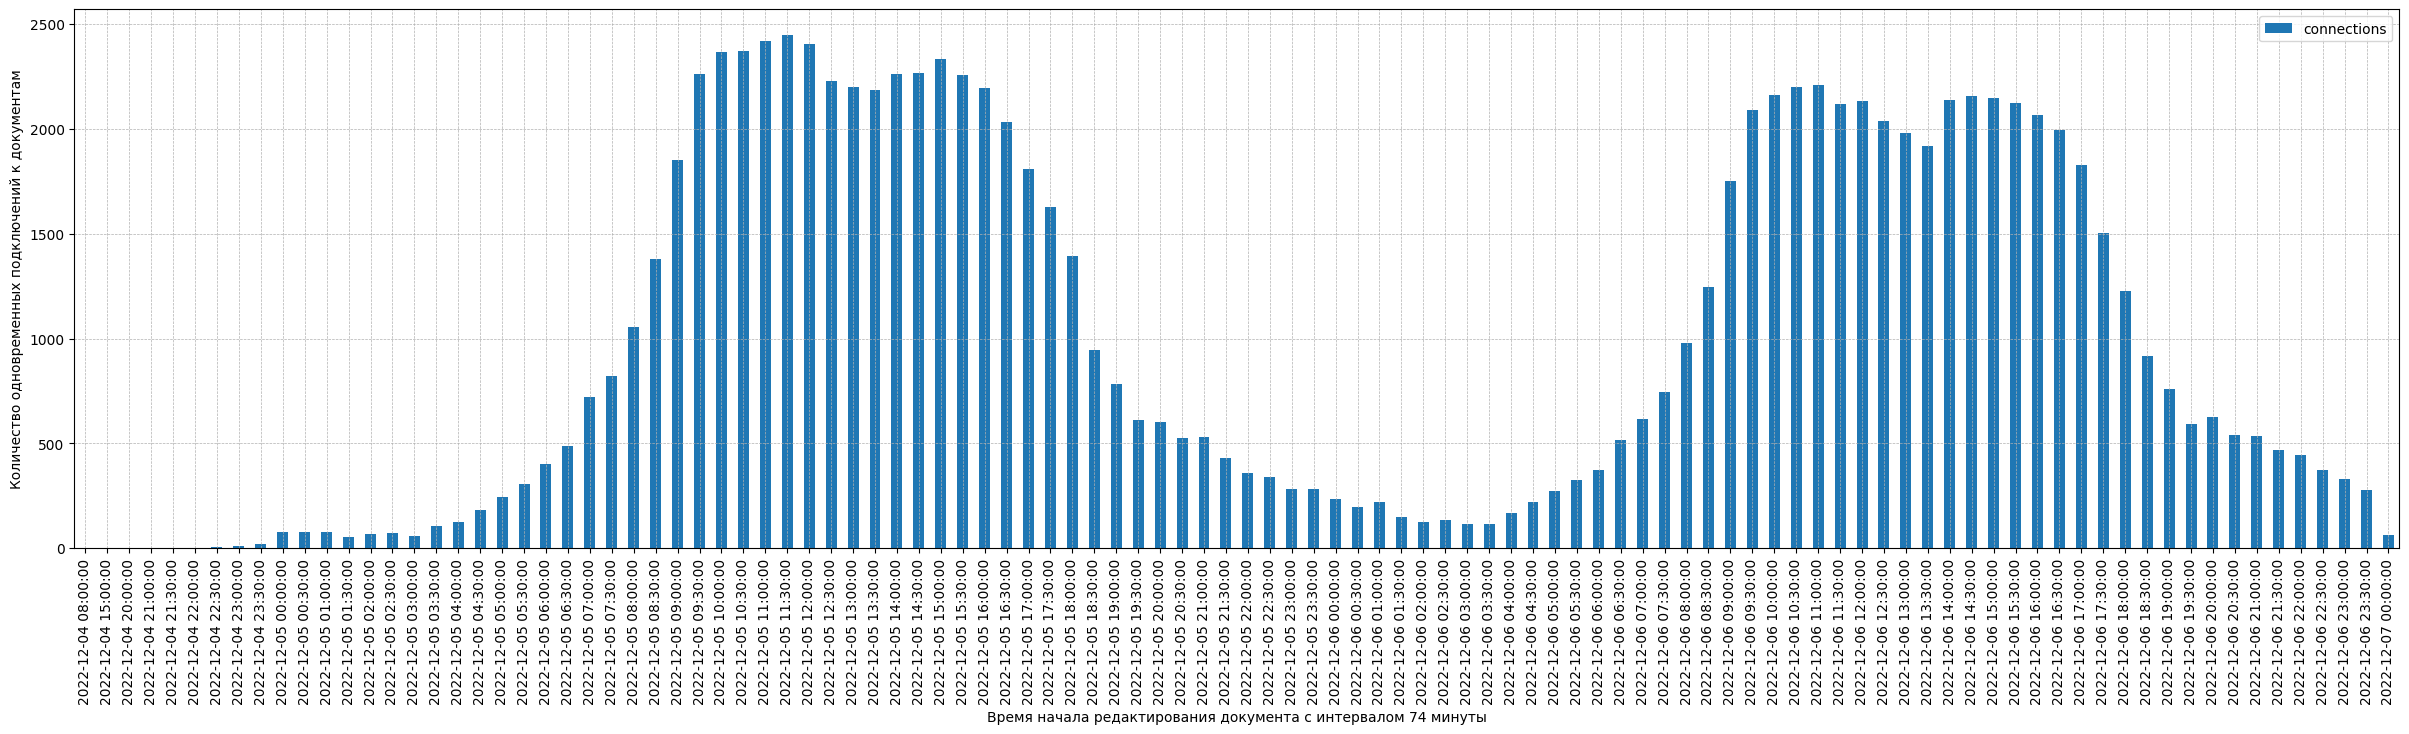

In [69]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# столбчатый график количества подключений по времени
ax =  connections_df.plot(x='start_edit_time', y='connections', kind = 'bar' , figsize=(30,7))

plt.grid(True, linestyle = '--', linewidth = 0.5)
plt.xlabel("Время начала редактирования документа с интервалом 74 минуты")
plt.ylabel("Количество одновременных подключений к документам")
plt.show()


Наблюдаемые пиковые моменты приходятся на промежуток времени с 7 утра до 18 вечера, что указывает на подключения к документам в рабочее время.

In [70]:
top_intervals = connections_df.sort_values(by='connections', ascending=False).head()
top_intervals

,start_edit_time,connections,tariff_id,doc_id,portal_type,db_name,server
32,2022-12-05 11:30:00,2448,"[ru_pro, ru_team_2019, ru_pro100, box, ru_std,...","[2761575866.0, 1015119789.0, 2125628358.0, 101...","[cloud, box]","[b22098008, b18576430, b16130674, b20768210, b...","[ms, ru, de, us]"
31,2022-12-05 11:00:00,2420,"[ru_pro, ru_team_2019, box, by_pro, ru_team, r...","[2506519679.0, 3099009545.0, 3150537226.0, 207...","[cloud, box]","[b2751613, b6531417, rimgroup24.ru, b21176728,...","[ms, ru, de, us]"
33,2022-12-05 12:00:00,2403,"[ru_company, kz_pro100, ru_std, en_pro, box, r...","[2076029986.0, 286956681.0, 1143265116.0, 1735...","[cloud, box]","[b1621421, b20617868, b21915266, b20830995, bi...","[ru, de, ms, us]"
30,2022-12-05 10:30:00,2372,"[ru_nfr, ru_pro100, ru_team_2019, ru_company, ...","[1583791929.0, 1857497282.0, 230433439.0, 2252...","[cloud, box]","[b3808793, b21629026, b9199145, b1335383, b190...","[ru, ms, de, us]"
29,2022-12-05 10:00:00,2368,"[ru_company, in_pro, box, ru_pro, ru_team_2019...","[1447678939.0, 3093109634.0, 3675466533.0, 132...","[cloud, box]","[b11780146, b18297514, b20199223, bitrix.tdgt....","[ms, ru, us, de]"


В таблице выше обнаружены интервалы с максимальным количеством подключений - первая половина дня и околообеденное время. 

In [71]:
grouped_data = data.groupby(['start_edit_time', 'db_name'])
max_connections = grouped_data['connections'].agg('sum')
max_db_name = max_connections.reset_index()
max_db_name.sort_values(by='connections', ascending=False).head()

,start_edit_time,db_name,connections
33576,2022-12-06 05:30:00,b23771533,25
38274,2022-12-06 09:30:00,b4245111,25
39582,2022-12-06 10:00:00,b5745095,22
39526,2022-12-06 10:00:00,b4245111,21
62122,2022-12-06 21:00:00,vandal.team,20


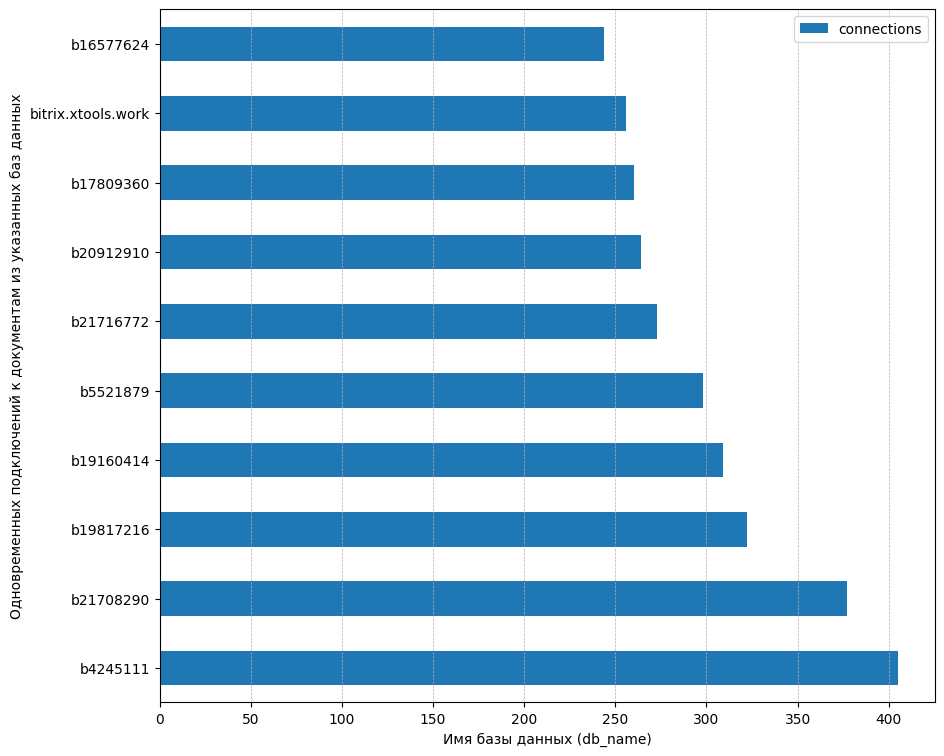

In [72]:

# Сруппировать данные по 'db_name' и вычислить сумму 'connections' для каждой группы
grouped_df = max_db_name.groupby('db_name').agg({'connections': 'sum'}).reset_index()

# Отсортировать результаты по убыванию значения 'connections'
sorted_df = grouped_df.sort_values(by='connections', ascending=False)

# Выбрать первые 10  строк
top_df = sorted_df.iloc[:10]

# Построить столбчатую диаграмму
top_df.plot.barh(x='db_name', y='connections', figsize = (10,9))
plt.grid(True, axis = 'x', linestyle = '--', linewidth = 0.5)
plt.xlabel("Имя базы данных (db_name)")
plt.ylabel("Одновременных подключений к документам из указанных баз данных")
plt.show()


In [73]:
grouped_data = data.groupby(['start_edit_time', 'tariff_id'])
max_connections = grouped_data['connections'].agg('sum')
max_tariff = max_connections.reset_index()
max_tariff.sort_values(by='connections', ascending=False).head()

,start_edit_time,tariff_id,connections
681,2022-12-05 10:00:00,ru_pro,788
628,2022-12-05 09:30:00,ru_pro,755
746,2022-12-05 10:30:00,ru_pro,736
897,2022-12-05 11:30:00,ru_pro,721
820,2022-12-05 11:00:00,ru_pro,720


Обнаруживаем, наиболее популярный tafiff_id с одновременными редактированиями. 

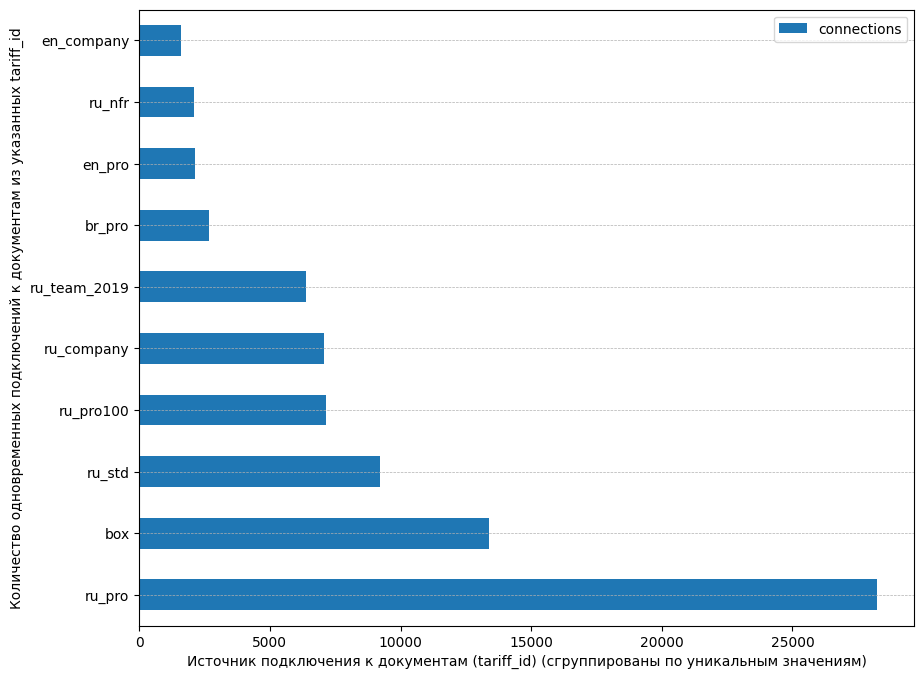

In [74]:

grouped_df = max_tariff.groupby('tariff_id').agg({'connections': 'sum'}).reset_index()
# Отсортировать результаты по убыванию значения 'connections'
sorted_df = grouped_df.sort_values(by='connections', ascending=False)

# Выбрать первые 10 строк
top_df = sorted_df.iloc[:10]

# Построить столбчатую диаграмму
top_df.plot.barh(x='tariff_id', y='connections', figsize = (10, 8))
plt.grid(True, axis = 'y', linestyle = '--', linewidth = 0.5)
plt.xlabel("Источник подключения к документам (tariff_id) (сгруппированы по уникальным значениям)")
plt.ylabel("Количество одновременных подключений к документам из указанных tariff_id")

plt.show()

In [75]:
grouped_data = data.groupby(['start_edit_time', 'server'])
max_connections = grouped_data['connections'].agg('sum')
max_server = max_connections.reset_index()

max_server.sort_values(by='connections', ascending=False).head()

,start_edit_time,server,connections
111,2022-12-05 11:30:00,ms,1236
103,2022-12-05 10:30:00,ms,1204
95,2022-12-05 09:30:00,ms,1178
107,2022-12-05 11:00:00,ms,1160
115,2022-12-05 12:00:00,ms,1154


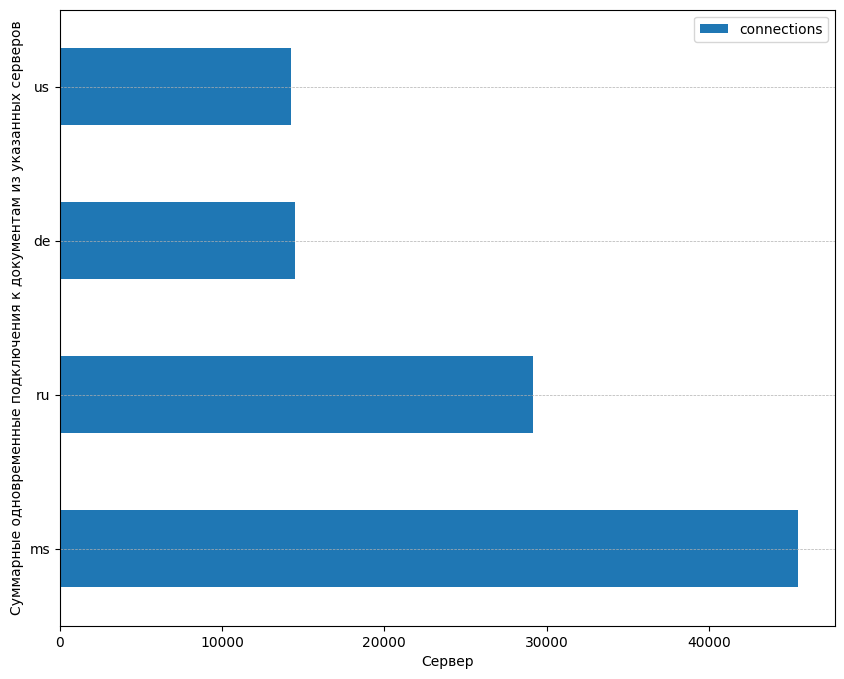

In [76]:

grouped_df = max_server.groupby('server').agg({'connections': 'sum'}).reset_index()
# Отсортировать результаты по убыванию значения 'connections'
sorted_df = grouped_df.sort_values(by='connections', ascending=False)

# Построить столбчатую диаграмму
sorted_df.plot.barh(x='server', y='connections', figsize = (10, 8))
plt.grid(True, axis = 'y', linestyle = '--', linewidth = 0.5)

plt.xlabel("Сервер")
plt.ylabel("Суммарные одновременные подключения к документам из указанных серверов")

plt.show()



In [77]:
grouped_data = data.groupby(['start_edit_time', 'portal_type'])
max_connections = grouped_data['connections'].agg('sum')
max_connections_df = max_connections.reset_index()
max_connections_df = max_connections_df.sort_values(by=['start_edit_time', 'connections'], ascending=[True, False])
max_portal_type = max_connections_df.groupby('start_edit_time').first().reset_index()
max_portal_type  = max_portal_type.sort_values(by='connections', ascending=False)
max_portal_type.head()

,start_edit_time,portal_type,connections
32,2022-12-05 11:30:00,cloud,2076
31,2022-12-05 11:00:00,cloud,2068
33,2022-12-05 12:00:00,cloud,2061
30,2022-12-05 10:30:00,cloud,2031
29,2022-12-05 10:00:00,cloud,2020


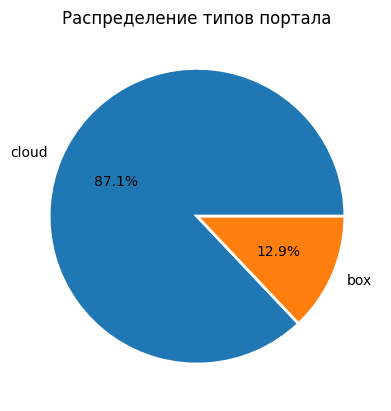

In [78]:
ax = data['portal_type'].value_counts().plot(kind='pie', wedgeprops={'edgecolor': 'white', 'linewidth': 2} , autopct='%1.1f%%')
ax.set_title('Распределение типов портала')
ax.set_ylabel('')
plt.show()


Выводы: 
 - Пиковое время подключений - 7 утра - 18 вечера, что соотвествует редактированию во время рабочего дня.
 - Обнаружены чрезмерно длительные подключения к документам (свыше 74 минут), они составляют 5% от общего числа подключений и могут являться причиной приближения к лимиту.
 - Список источников (tariff_id) из 88 наименований предоставлен выше, такие источники используют пользователи (свыше 3600 уникальных), выбивающиеся по времени редактирования документов.
 - Наиболее популярный сервер, с которого максимум одновременных редактирований - ms.
 - Наиболее популярный тип портала - cloud.
 - Наиболее популярный tariff_id с одновременными редактированиями - ru_pro.
 - Максимальное количество одновременных подключений - 2448, что приближенно к установленному лимиту в 3000.


Рекомендации: 
- Проверить возможные причины аномально длительного времени редактирования документов. Возможно некорректный сбор данных или особые условия пользования конкретными tariff_id.
- В случае возможности распределить лимиты по времени уменишить пропускную способность на редактирование в промежуток с 18 до 7 с целью экономии.